In [1]:
# Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE
import itertools
from IPython.display import Markdown as md

In [2]:
# Variable
PROJECT_SHORT = "MSNA_2023_SYR"
DELETION_SHEET_NAME = "deletion"
DELETION_AUDIT_CHECK_REASON = "(audit checks)"
RAW_DATA_ID_MAPPING = ["_id", "audit_id"]


# Load Data

In [4]:

# Features
features_path = "../data/{}/features.xlsx".format(PROJECT_SHORT)
features_df = pd.read_excel(features_path)

# Raw Data
raw_data_path = "../data/{}/raw_data.xlsx".format(PROJECT_SHORT)
raw_data_df = pd.read_excel(raw_data_path)

# Deletion Logs
dl_path = "../data/{}/raw_deletion_logs.xlsx".format(PROJECT_SHORT)
dl_df = pd.read_excel(dl_path, sheet_name = DELETION_SHEET_NAME)

# Anomaly Labelisation 

In [5]:
# Get raw data ID mapping
id_map = raw_data_df[RAW_DATA_ID_MAPPING]

# Merge audit id with deletion log
dl_audit_id = dl_df.merge(id_map, left_on='id', right_on='_id', how='left')

# Merge with features df
MERGE_VAR = ["audit_id", "Calc_Enum_code_Unique_Identifier", "reason"]
features_labeled = features_df.merge(dl_audit_id[MERGE_VAR], on='audit_id', how='left')
 
features_labeled['anomaly_label'] = features_labeled['reason'].str.contains(DELETION_AUDIT_CHECK_REASON,
                                                                            na=False,
                                                                            regex=False).astype(int)

# Deleted Labelisation

In [6]:
# Indicatrice if survey is deleted in the deletion logs
features_labeled['deleted_label'] = features_labeled['reason'].notna().astype(int)

# Var if deleted or not in the deletion log with distinction if deleted between audit check reason and other
conditions = [
    (features_labeled['anomaly_label'] == 1),
    (features_labeled['anomaly_label'] == 0) & (features_labeled['deleted_label'] == 1)
]
choices = ['audit', 'other']

# Créer la nouvelle variable
features_labeled['deleted_reason'] = np.select(conditions, choices, default='not_deleted')

In [7]:
# Save labeled features df
features_labeled_path = "../data/{}/features_labeled.xlsx".format(PROJECT_SHORT)
features_labeled.to_excel(features_labeled_path)

# Graphical Analysis

In [75]:
target = 'anomaly_label'
col_to_remove = ["audit_id", "enum_id", "Calc_Enum_code_Unique_Identifier"]
df = features_labeled.drop(columns=col_to_remove)
df

,unique_question_duration_correlation,log_longer_shorter_median_pace_ratio,active_time_spent_seconds,survey_start_std,max_survey_start_span,median_survey_start_span,active_time_that_day_seconds,active_fraction_before_long_break,largest_relative_pace_increase,duration,...,variance,constraint_note_count,constraint_backtracks_count,constraint_error_count,median_active_seconds_per_day,median_active_seconds_per_survey,reason,anomaly_label,deleted_label,deleted_reason
0,0.576314,0.191588,2071.310,1.444032,5,2,3.391163e+06,1.0,1.393656,63.373383,...,1.613500,15,4,0,2997872.125,2658.543,NaN,0,0,not_deleted
1,0.766138,-0.661136,2441.614,1.905889,7,2,1.223330e+07,1.0,1.138550,57.753433,...,1.309466,5,10,0,5766849.125,3564.547,NaN,0,0,not_deleted
2,0.851329,1.593959,2270.490,2.629956,9,2,1.397023e+06,1.0,0.986384,56.346200,...,0.039980,9,11,1,2635781.582,3289.348,NaN,0,0,not_deleted
3,0.233428,2.006507,3373.627,2.049538,9,2,2.207840e+06,1.0,4.788192,56.923483,...,0.324006,6,7,0,1111757.549,1874.536,NaN,0,0,not_deleted
4,0.734949,0.917235,809.268,3.207068,12,2,1.511277e+06,1.0,1.262081,46.113450,...,8.140193,2,0,0,1511277.449,2075.514,NaN,0,0,not_deleted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,0.764558,-0.885747,3789.375,1.284664,4,2,1.610870e+06,1.0,1.197686,63.180383,...,0.445912,2,1,0,1856665.838,3783.904,NaN,0,0,not_deleted
6230,0.706611,-1.240826,3780.839,1.319784,5,2,3.342460e+06,1.0,1.202257,63.044650,...,0.651730,4,5,0,1939529.074,4094.560,NaN,0,0,not_deleted
6231,0.835631,-1.181143,2759.393,1.319784,5,2,1.225966e+06,1.0,0.873956,62.752933,...,1.815174,3,4,0,1939529.074,4094.560,NaN,0,0,not_deleted
6232,0.696574,2.631584,2024.977,2.049538,9,2,2.709455e+06,1.0,1.065682,34.731000,...,0.119538,3,10,0,1111757.549,1874.536,NaN,0,0,not_deleted


ValueError: num must be an integer with 1 <= num <= 22, not 23

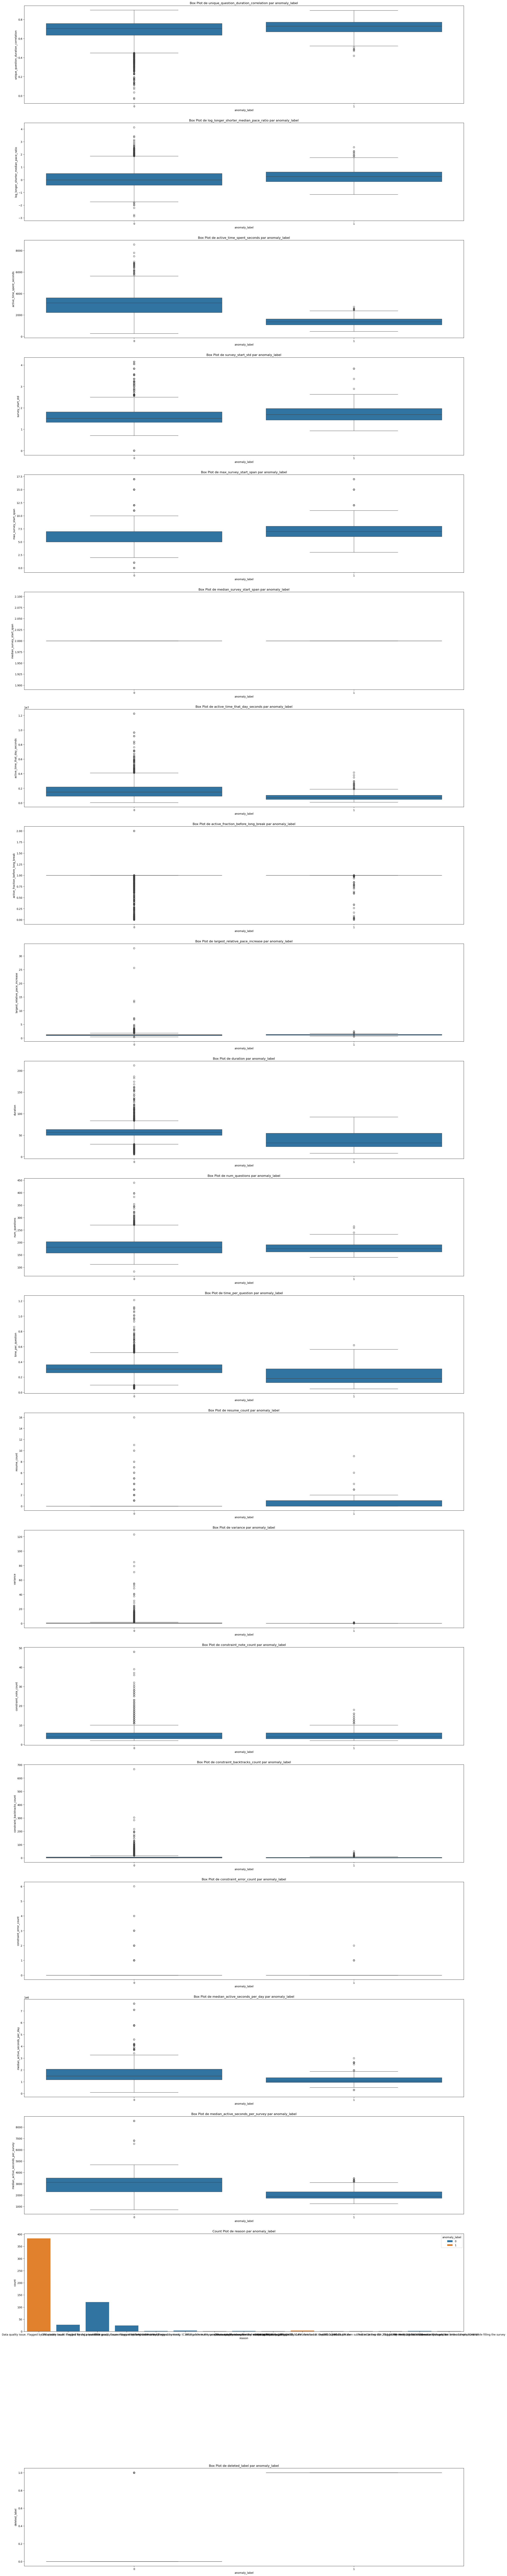

In [76]:

# Variable cible
# Initialisation de la figure
n_cols = 1
n_rows = math.ceil((len(df.columns) - 1) / n_cols)  # -1 pour exclure la variable cible

plt.figure(figsize=(30, n_rows * 8))

# Parcourir chaque colonne (caractéristique) du DataFrame
for i, column in enumerate(df.columns):
    if column != target:
        plt.subplot(n_rows, n_cols, i + 1)
        if df[column].dtype == 'object':  # Si la colonne est de type catégoriel
            sns.countplot(x=column, hue=target, data=df)
            plt.title(f"Count Plot de {column} par {target}")
        else:  # Si la colonne est de type numérique
            sns.boxplot(x=target, y=column, data=df)
            plt.title(f"Box Plot de {column} par {target}")

# Ajuster les espacements
plt.tight_layout()
plt.show()

<Axes: xlabel='median_active_seconds_per_survey', ylabel='Density'>

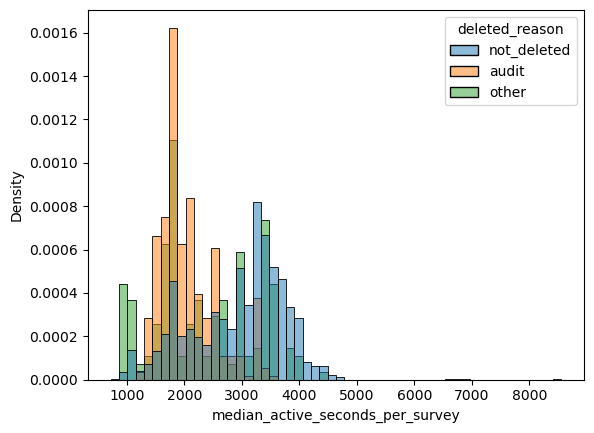

In [100]:
sns.histplot(data=features_labeled, x="median_active_seconds_per_survey", hue="deleted_reason",
             multiple="layer", stat="density", common_norm=False)

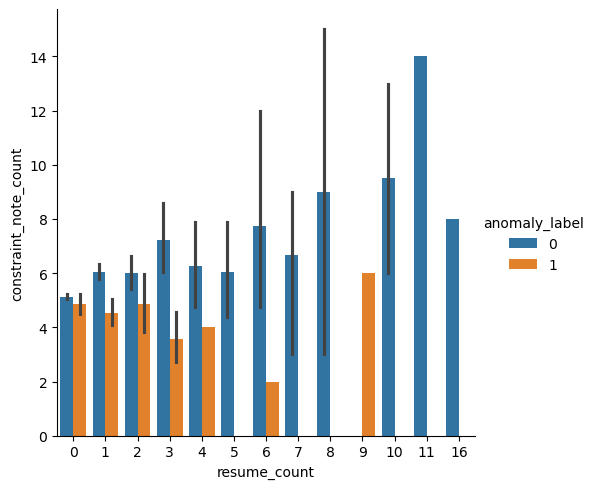

In [126]:
sns.catplot(data=features_labeled, x="resume_count", y ="constraint_note_count", hue="anomaly_label", kind="bar")

# Heat Map

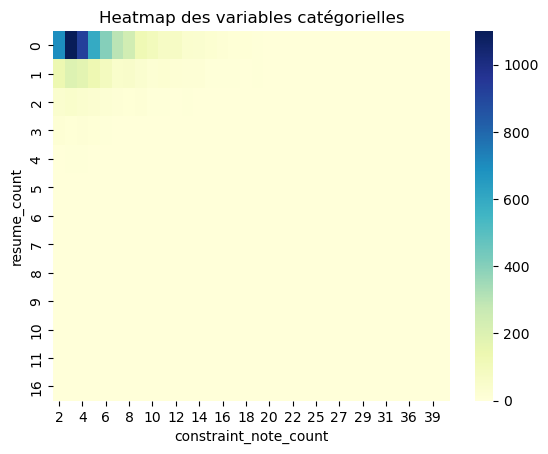

In [192]:
contingency_table = pd.crosstab(features_labeled['resume_count'], features_labeled['constraint_note_count'])

# Création de la heatmap
sns.heatmap(contingency_table, annot=False, fmt="d", cmap="YlGnBu",)
plt.title('Heatmap des variables catégorielles')
plt.show()

<Axes: xlabel='resume_count', ylabel='constraint_note_count'>

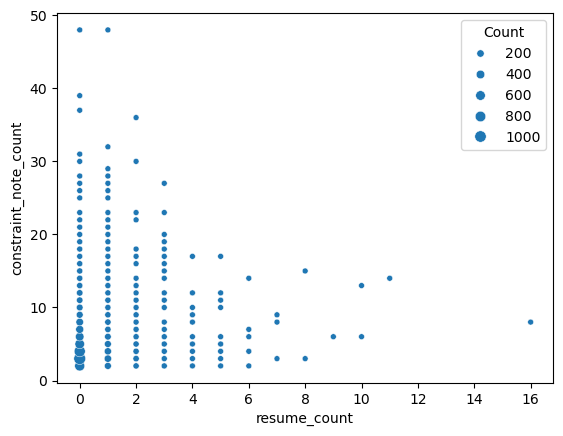

In [193]:
df_long = contingency_table.reset_index().melt(id_vars='resume_count', var_name='constraint_note_count', value_name='Count')
df_long = df_long[df_long['Count'] > 0]

sns.scatterplot(data=df_long, x="resume_count", y="constraint_note_count", size="Count")


# Bivariate Analysis

In [ ]:
# Variable cible
# Initialisation de la figure
n_cols = 1
n_rows = math.ceil((len(df.columns) - 1) / n_cols)  # -1 pour exclure la variable cible

plt.figure(figsize=(30, n_rows * 8))

# Parcourir chaque colonne (caractéristique) du DataFrame
for i, column in enumerate(df.columns):
    if column != target:
        plt.subplot(n_rows, n_cols, i + 1)
        if df[column].dtype == 'object':  # Si la colonne est de type catégoriel
            sns.countplot(x=column, hue=target, data=df)
            plt.title(f"Count Plot de {column} par {target}")
        else:  # Si la colonne est de type numérique
            sns.boxplot(x=target, y=column, data=df)
            plt.title(f"Box Plot de {column} par {target}")

# Ajuster les espacements
plt.tight_layout()
plt.show()

In [389]:
target = 'deleted_reason'
col_to_remove_bivariate = ["audit_id", "enum_id", "Calc_Enum_code_Unique_Identifier", "reason", "anomaly_label", "deleted_label", "median_survey_start_span"]
df_biv = features_labeled.drop(columns=col_to_remove_bivariate)

var_col = list(df_biv.columns)
var_col.remove(target)
col_combinaisons = list(itertools.combinations(var_col, 2))

In [398]:
a="TEST CA MAMA"
md("# The data consists of {} observations. Bla, Bla, ....".format(a))

# The data consists of TEST CA MAMA observations. Bla, Bla, ....

# We have the variable a={{a}}.

-------------------------------------------
BIVARIATE ANALYSIS OF unique_question_duration_correlation AND log_longer_shorter_median_pace_ratio
-------------------------------------------


/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


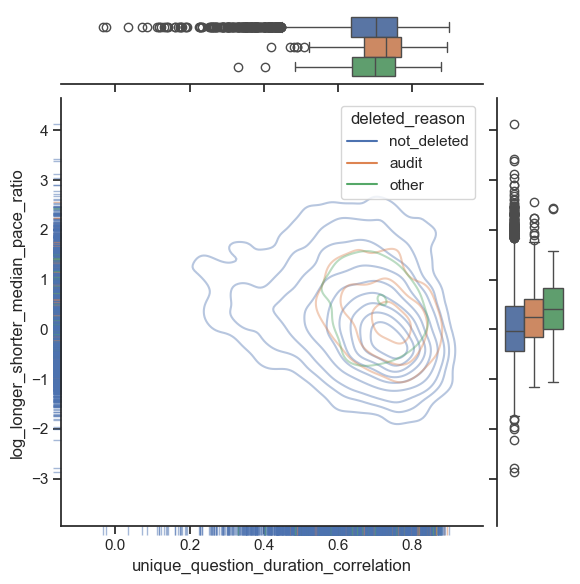

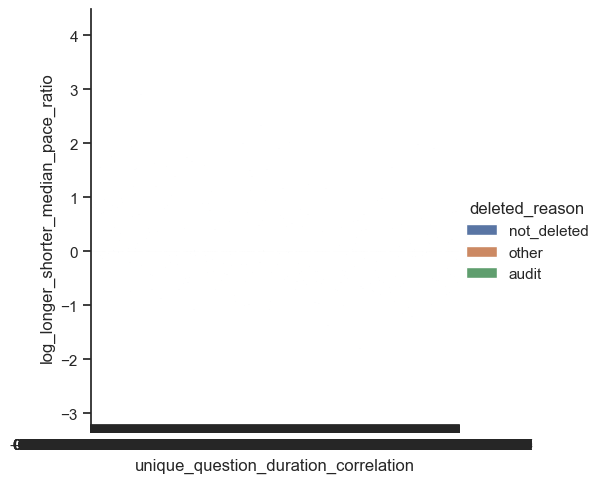

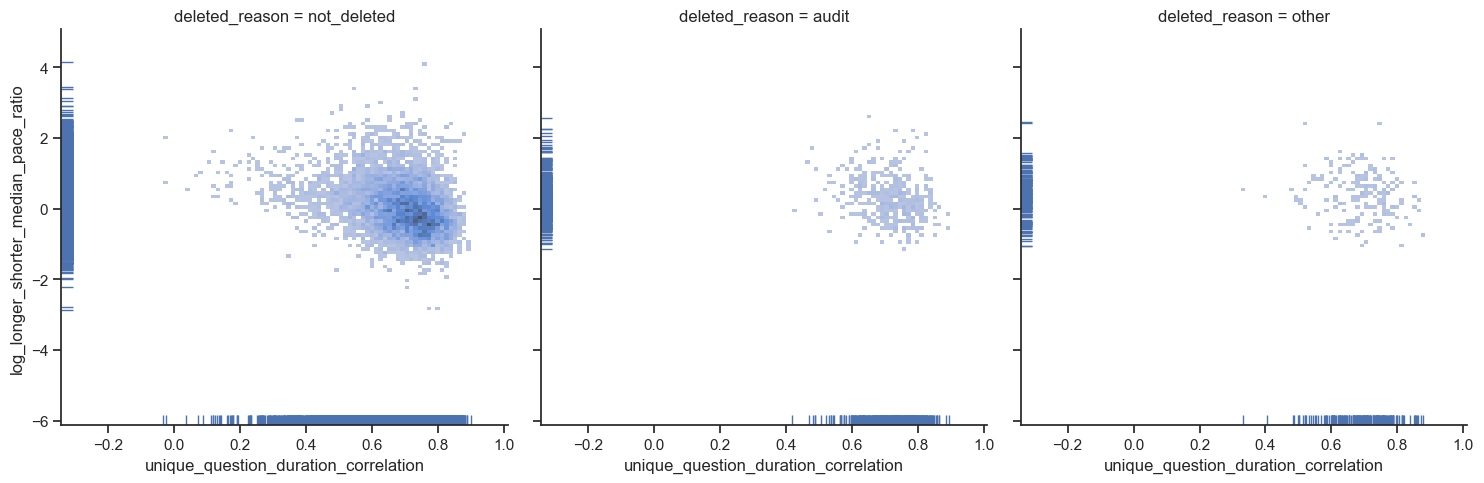

-------------------------------------------
BIVARIATE ANALYSIS OF unique_question_duration_correlation AND active_time_spent_seconds
-------------------------------------------


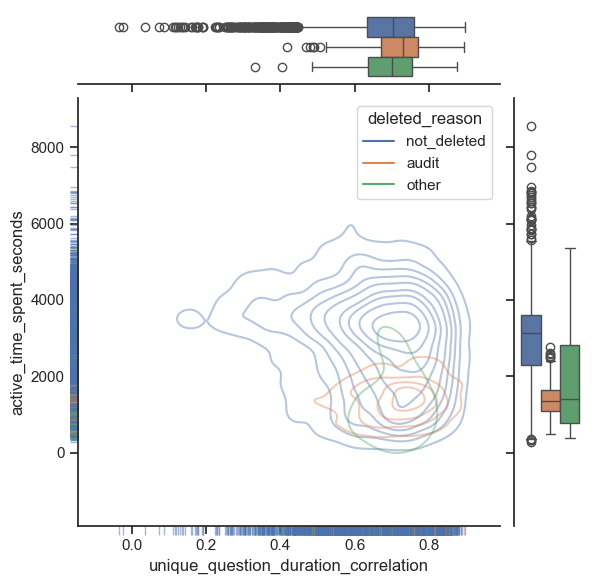

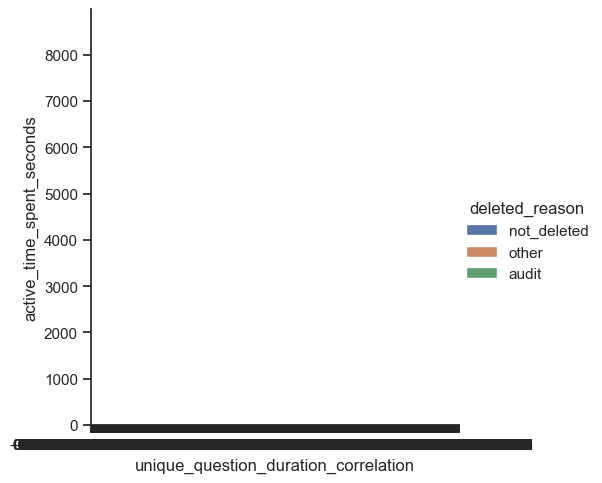

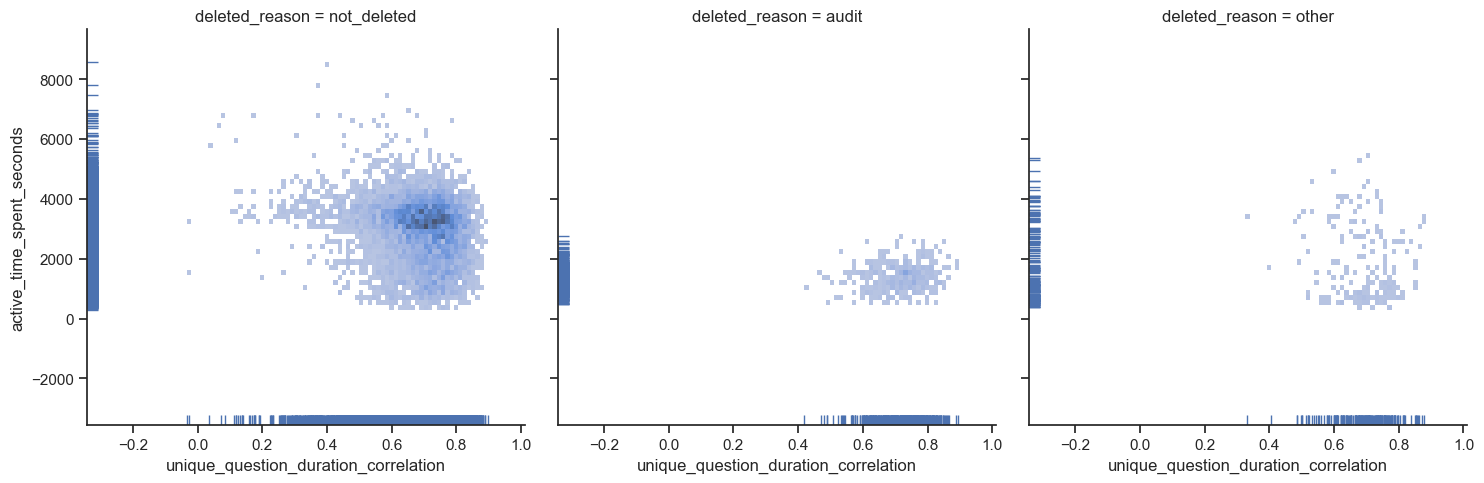

-------------------------------------------
BIVARIATE ANALYSIS OF unique_question_duration_correlation AND survey_start_std
-------------------------------------------


/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


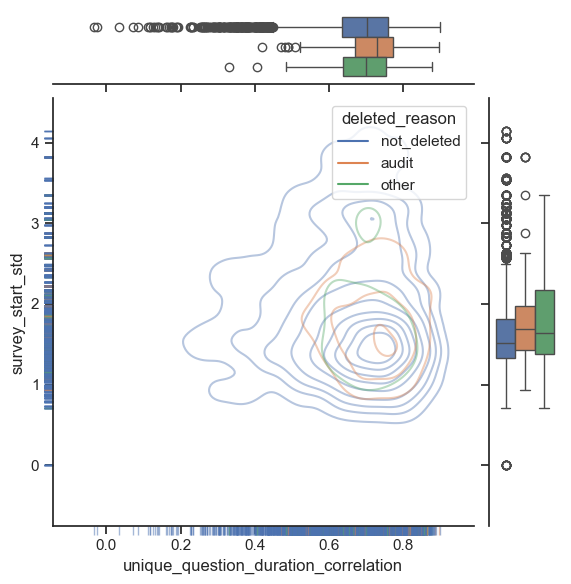

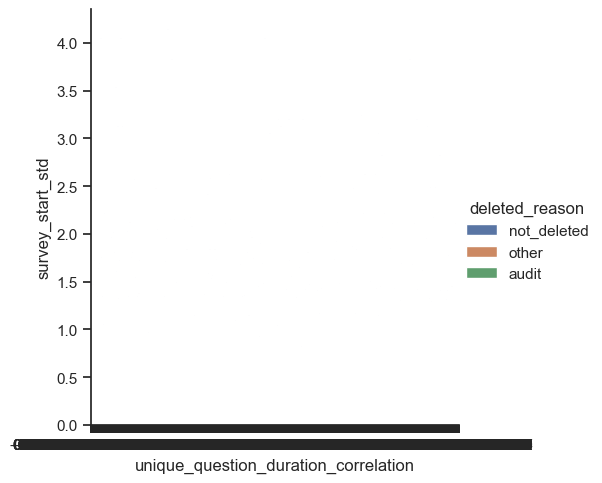

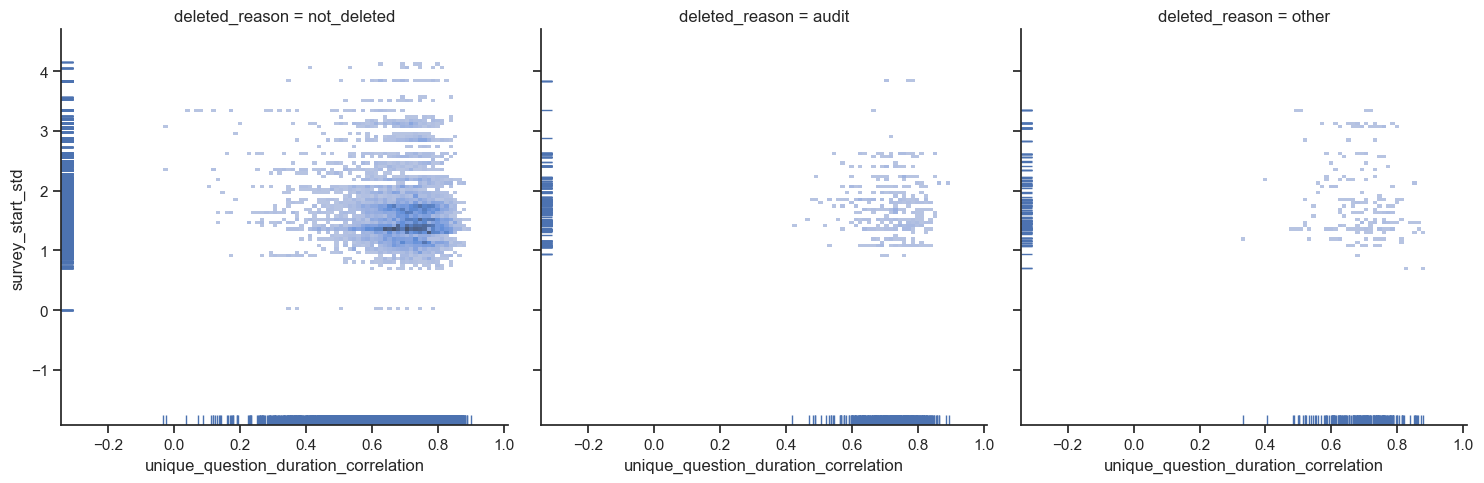

-------------------------------------------
BIVARIATE ANALYSIS OF unique_question_duration_correlation AND max_survey_start_span
-------------------------------------------


/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


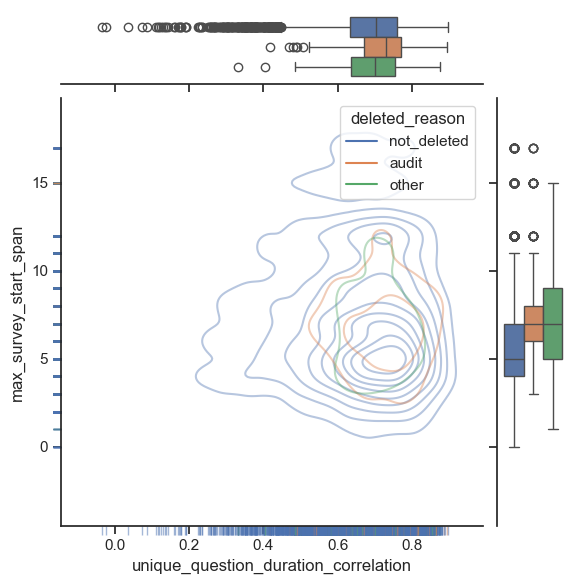

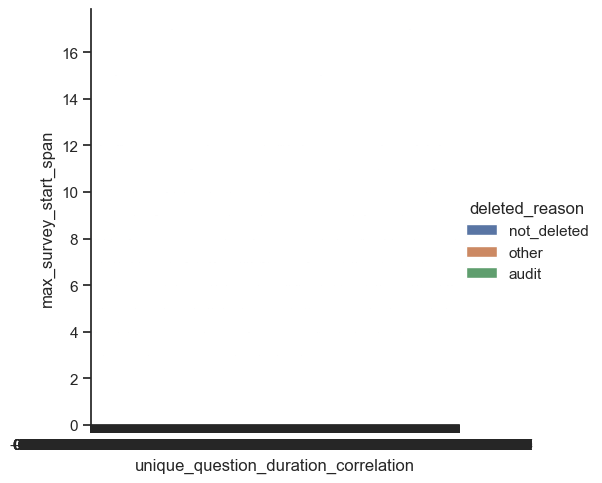

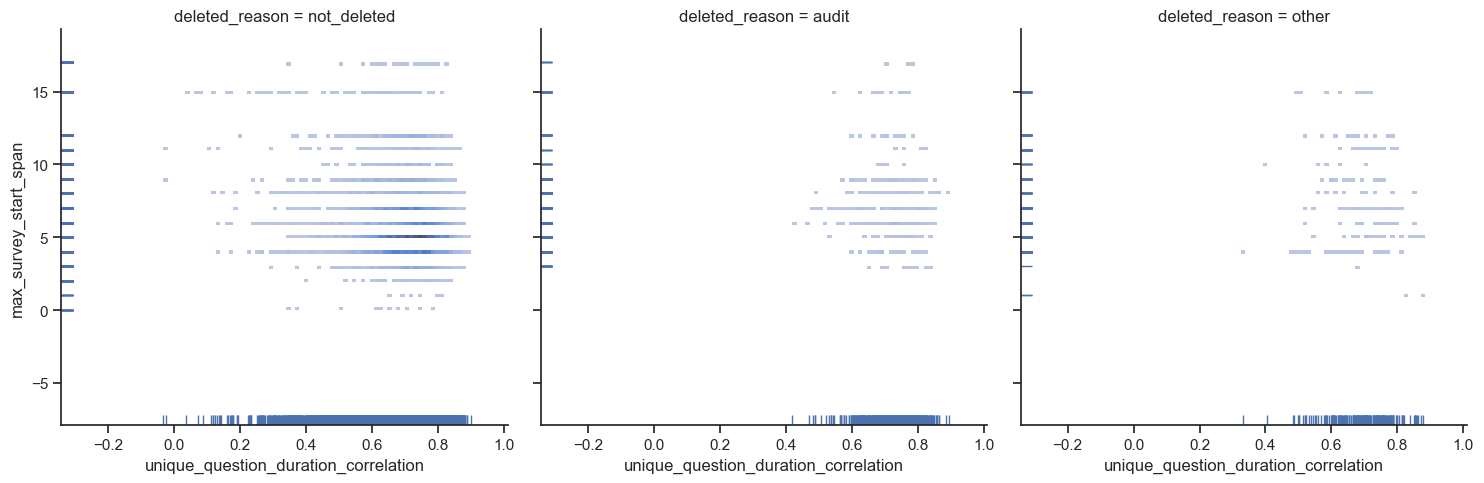

-------------------------------------------
BIVARIATE ANALYSIS OF unique_question_duration_correlation AND median_survey_start_span
-------------------------------------------


/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=self.x, y=self.y, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=self.x, y=self.y, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/audit_anomaly_analyse/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=self.x, y=self.y, **kwargs)


IndexError: cannot do a non-empty take from an empty axes.

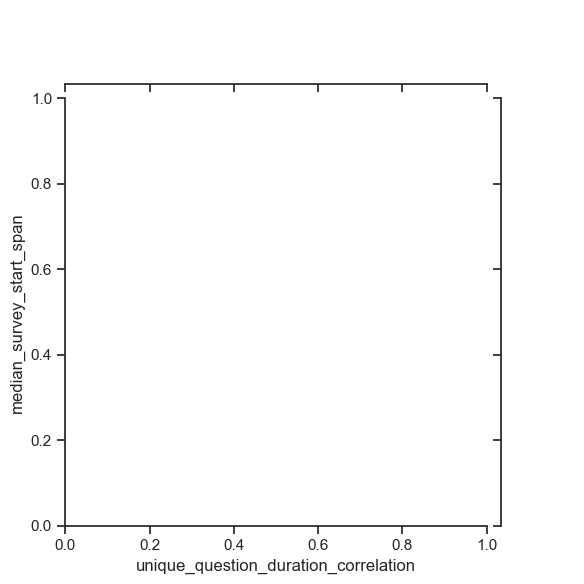

In [394]:
# Parcourir chaque colonne (caractéristique) du DataFrame
for comb in col_combinaisons:
    X = comb[0]
    Y = comb[1]
    print("-------------------------------------------")
    print("BIVARIATE ANALYSIS OF {} AND {}".format(X,Y))
    print("-------------------------------------------")
    # KDE ploy
    g1 = sns.JointGrid(data=features_labeled, x=X, y=Y,  hue=target)
    g1.plot_joint(sns.kdeplot, fill=False, alpha=0.4, common_norm=True)
    g1.plot_joint(sns.rugplot, height=-.02, clip_on=False, alpha=.5 )
    g1.plot_marginals(sns.boxplot)
    # Cat plot
    g2 = sns.catplot(data=features_labeled, x=X, y =Y, hue=target, kind="bar")
    # Dis plot by deleted reason (col)
    g3 = sns.displot(features_labeled, x=X, y=Y, col=target,
                     rug=True)
    plt.show()



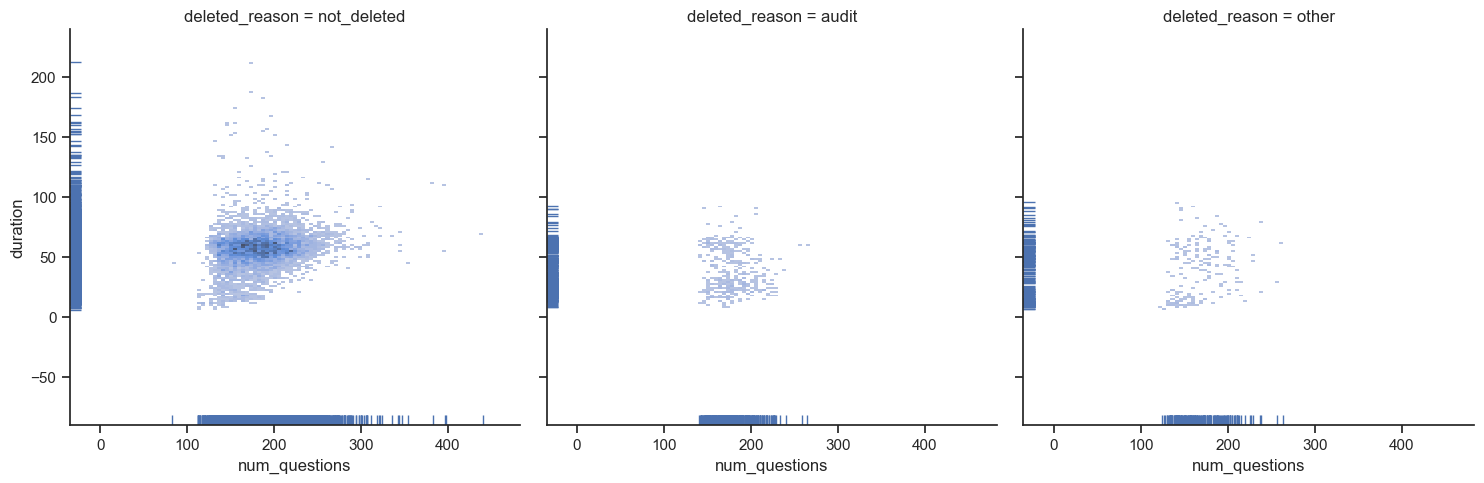

In [288]:
sns.displot(features_labeled, x="num_questions", y="duration", col="deleted_reason",
             rug=True)

--------------------------
----------------------------
# DEV PART 
-----------------------------------------------------------------------------
------------------------------------------------------------------------------

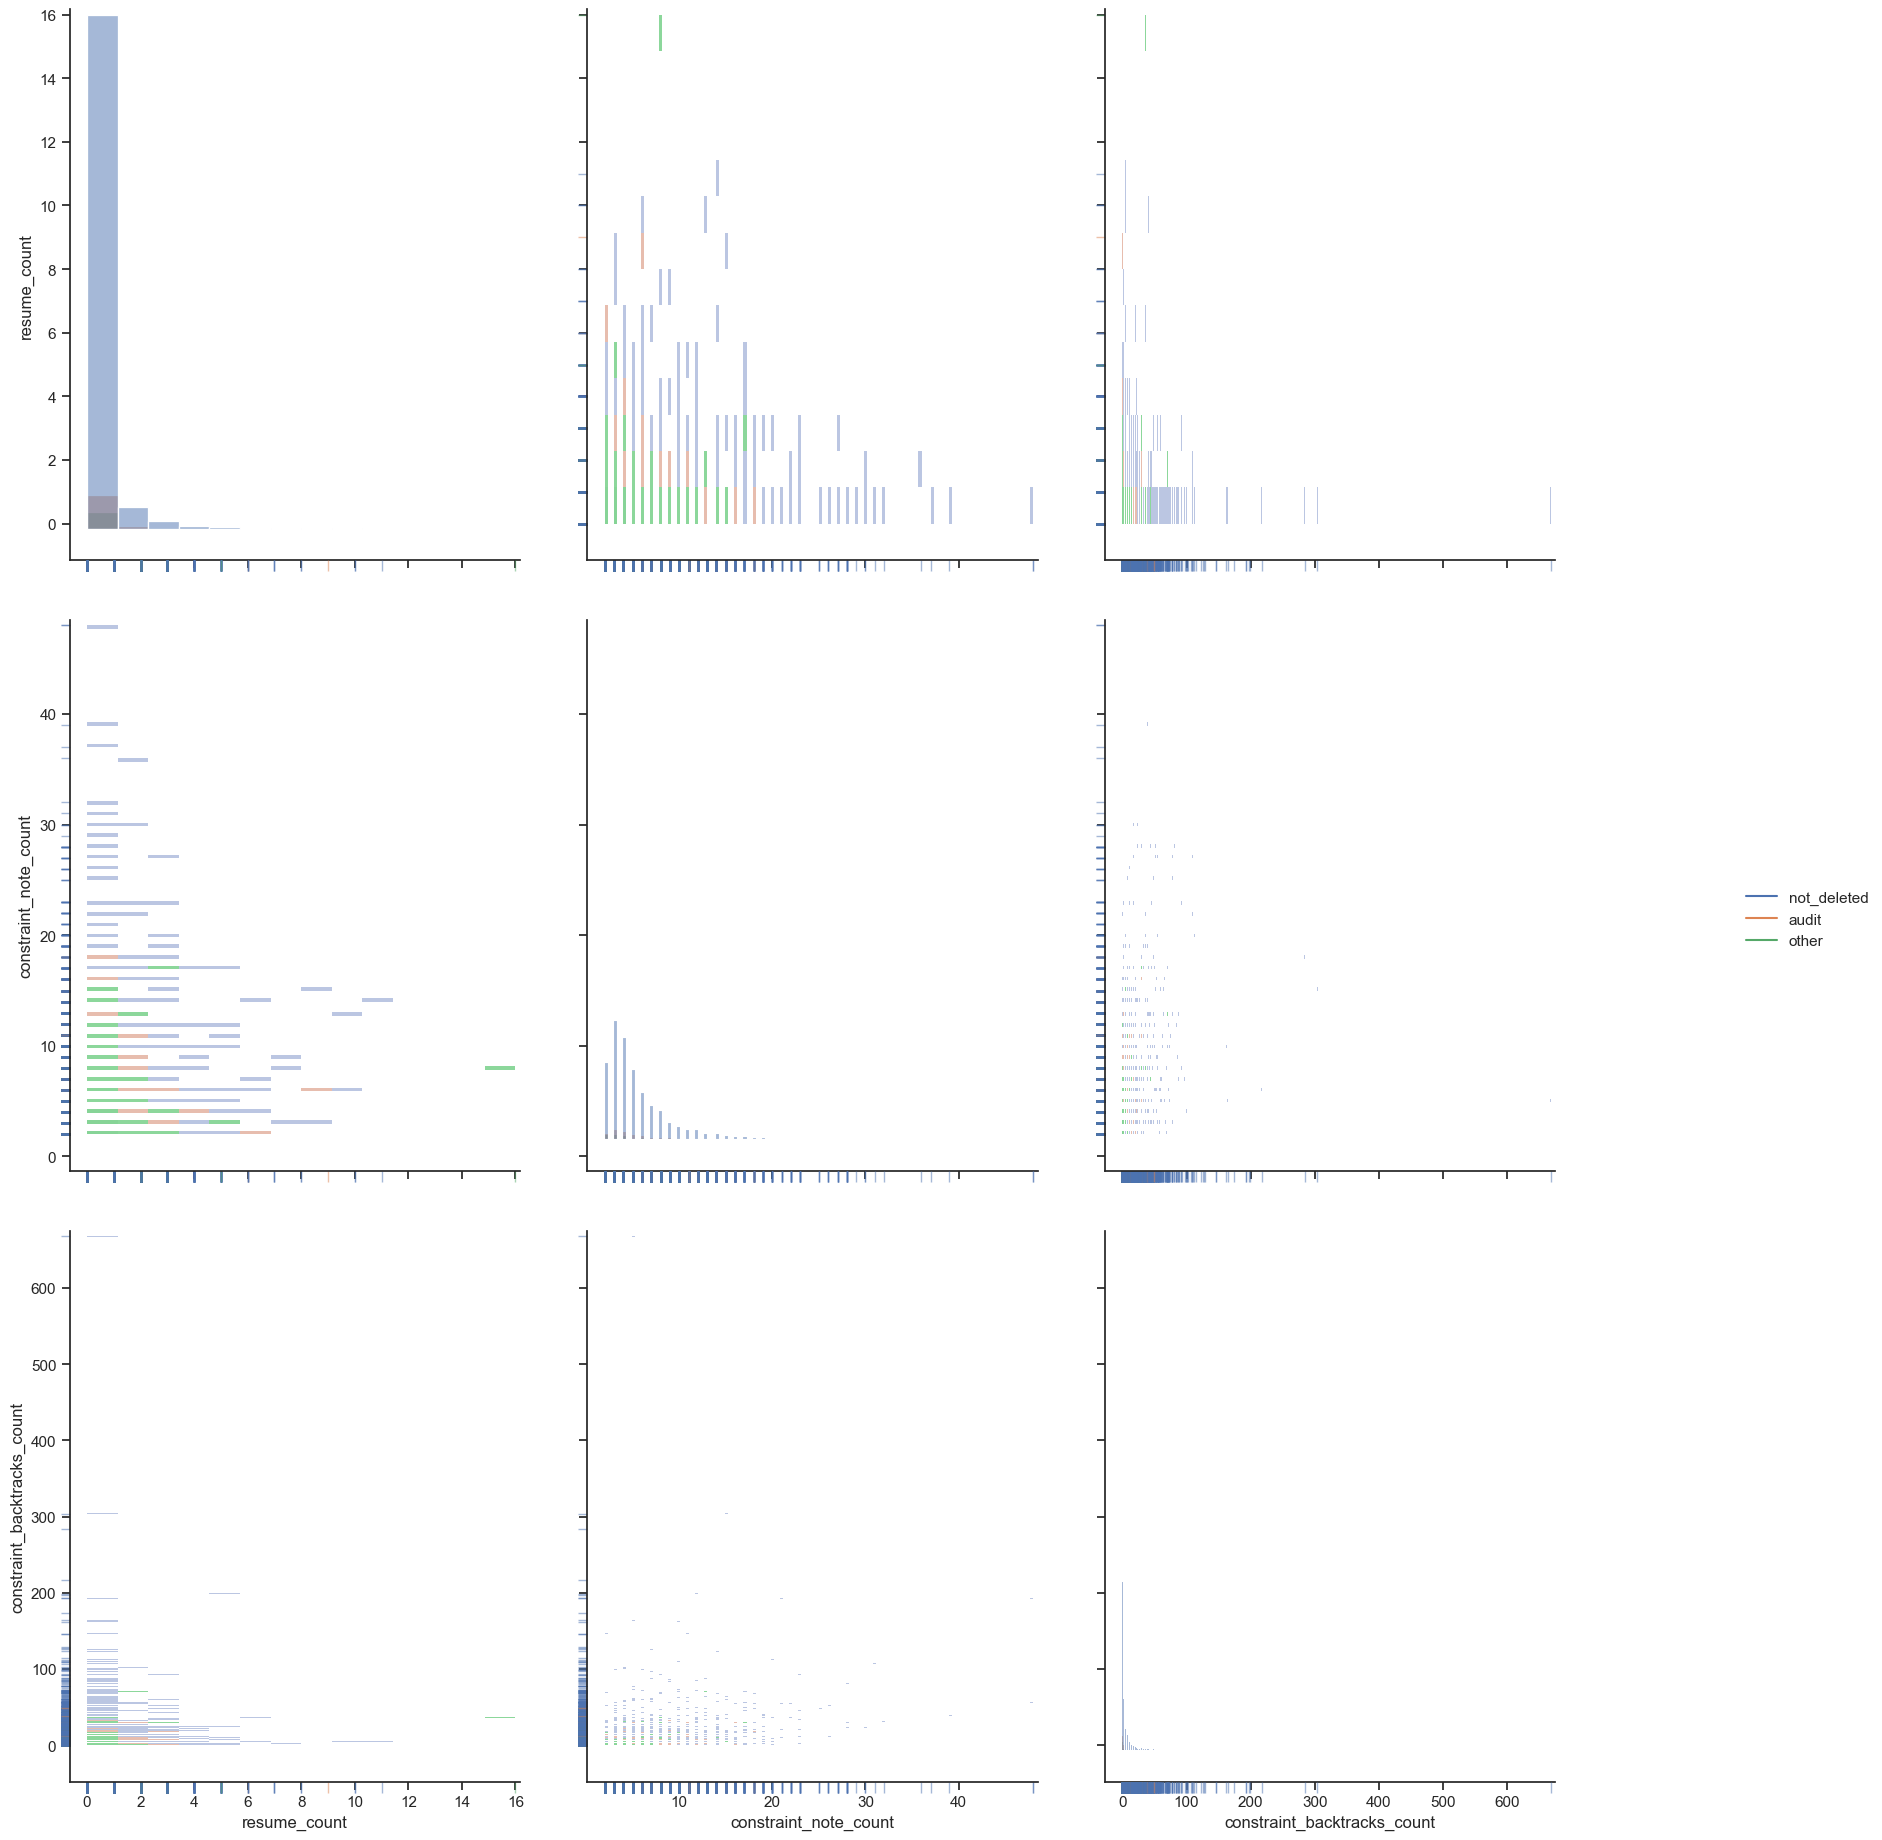

In [280]:
constraint_features = ["resume_count", "constraint_note_count", "constraint_backtracks_count"]
g = sns.PairGrid(features_labeled, vars=constraint_features, hue="deleted_reason")
g.map_diag(sns.histplot)
g.map_diag(sns.rugplot, height=-.02, clip_on=False, alpha=.5 )
g.map_offdiag(sns.histplot)
g.map_offdiag(sns.rugplot, height=-.02, clip_on=False, alpha=.5 )
g.add_legend(title="", adjust_subtitles=True)
g.fig.set_size_inches(20, 20)  # Ajustez selon le nombre de variables et la complexité des graphiques

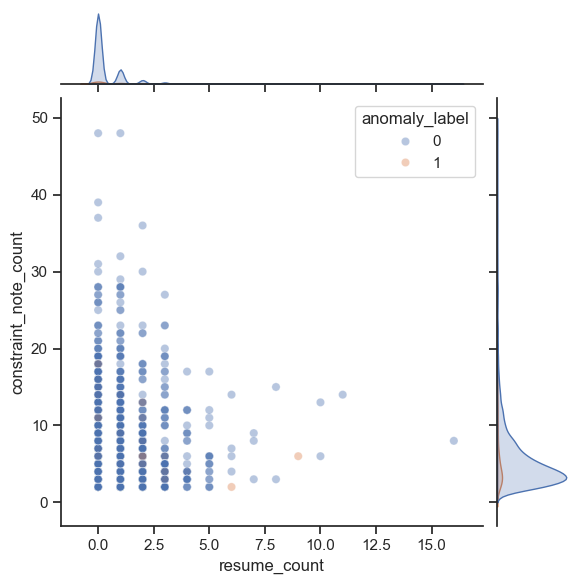

In [234]:

plt.figure(figsize=(30,20))
sns.displot(features_labeled, x="resume_count", y="constraint_note_count",
             rug=False, kind="kde", hue="anomaly_label", cbar=True)
sns.rugplot(data=features_labeled, x="resume_count", y="constraint_note_count", hue="anomaly_label",
            height=-.02, clip_on=False, alpha=.05, legend=False)



sns.displot(features_labeled, x="resume_count", y="constraint_note_count",
             rug=True, col="deleted_reason", alpha=1)

In [ ]:
sns.histplot(data=features_labeled, x="median_active_seconds_per_survey", hue="deleted_reason",
             multiple="layer", stat="density", common_norm=False)

<Axes: xlabel='resume_count', ylabel='constraint_note_count'>

<Figure size 3000x2000 with 0 Axes>

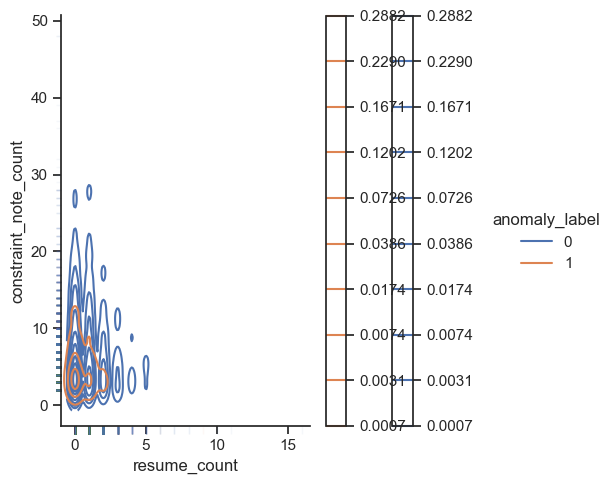

In [225]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(30,20))
sns.displot(features_labeled, x="resume_count", y="constraint_note_count",
             rug=False, kind="kde", hue="anomaly_label", cbar=True)
sns.rugplot(data=features_labeled, x="resume_count", y="constraint_note_count", hue="anomaly_label",
            height=-.02, clip_on=False, alpha=.05, legend=False)
# g = g.set(xlim=(-5,15),ylim=(-5,50))
# plt.show(g)

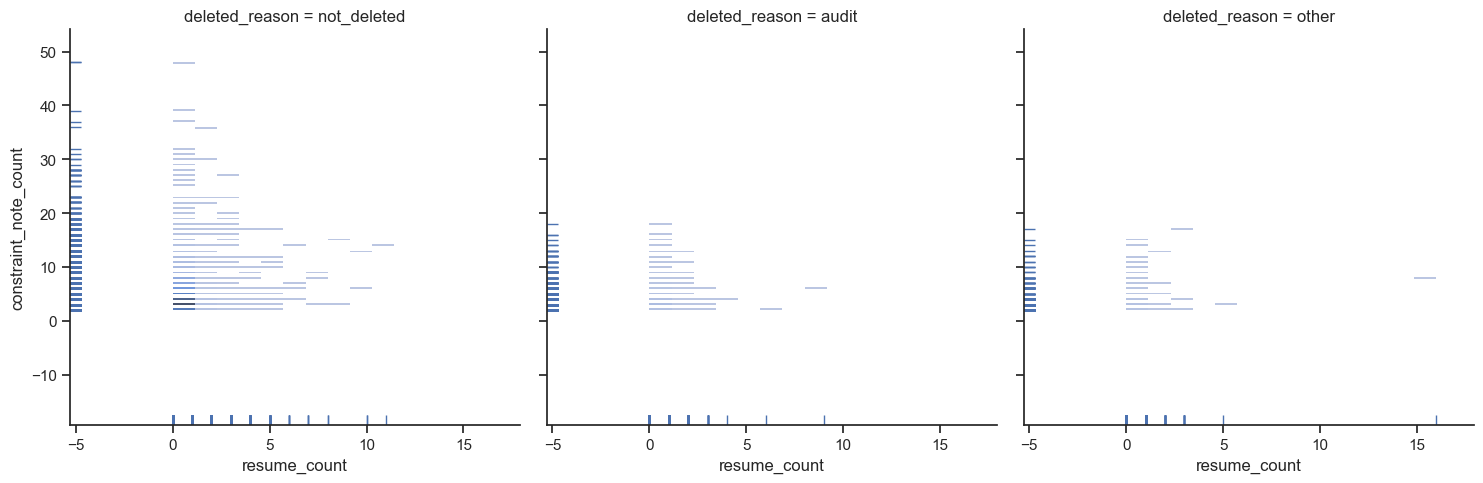

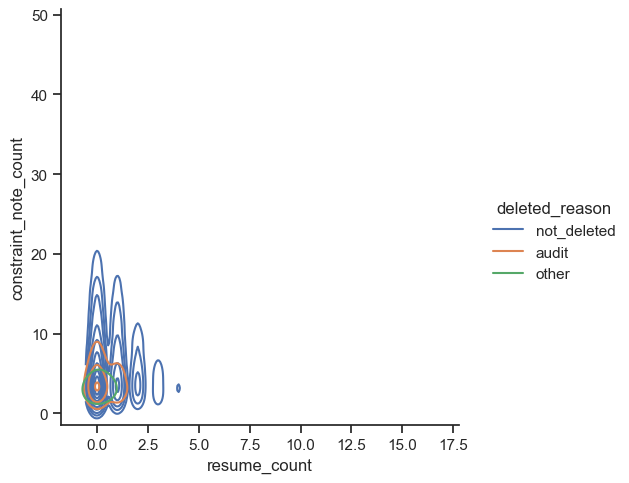

In [261]:
sns.displot(features_labeled, x="resume_count", y="constraint_note_count",
            rug=False, kind="kde", hue="deleted_reason", common_norm=True,
            thresh=.1, levels=10) 



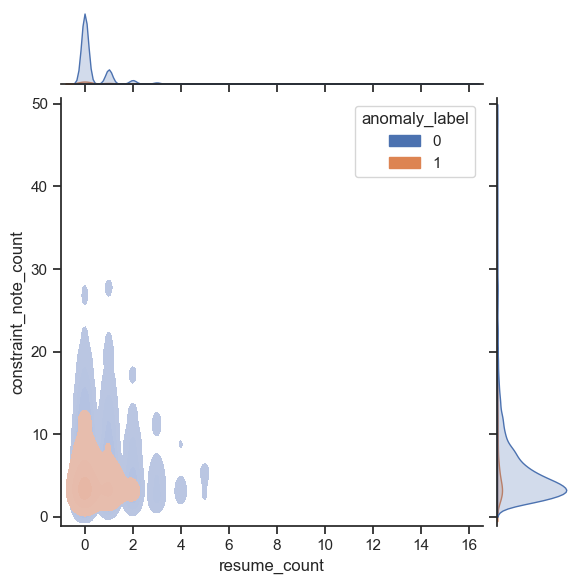

In [229]:
sns.jointplot(data=features_labeled, x="resume_count", y="constraint_note_count",
               hue="anomaly_label", alpha= 1, kind = "kde", fill=True )

In [183]:
features_labeled.columns

Index(['audit_id', 'enum_id', 'unique_question_duration_correlation',
       'log_longer_shorter_median_pace_ratio', 'active_time_spent_seconds',
       'survey_start_std', 'max_survey_start_span', 'median_survey_start_span',
       'active_time_that_day_seconds', 'active_fraction_before_long_break',
       'largest_relative_pace_increase', 'duration', 'num_questions',
       'time_per_question', 'resume_count', 'variance',
       'constraint_note_count', 'constraint_backtracks_count',
       'constraint_error_count', 'median_active_seconds_per_day',
       'median_active_seconds_per_survey', 'Calc_Enum_code_Unique_Identifier',
       'reason', 'anomaly_label', 'deleted_label', 'deleted_reason'],
      dtype='object')

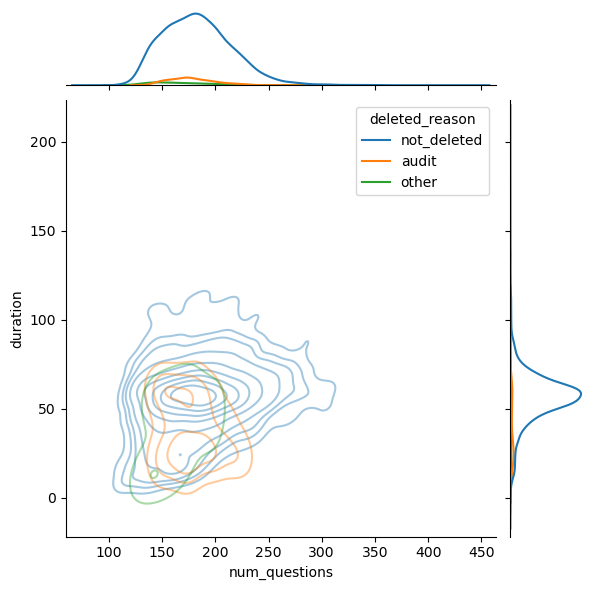

In [188]:
sns.jointplot(data=features_labeled, x="num_questions", y="duration",
               hue="deleted_reason", common_norm=True,  kind="kde", fill=False, alpha=0.4)

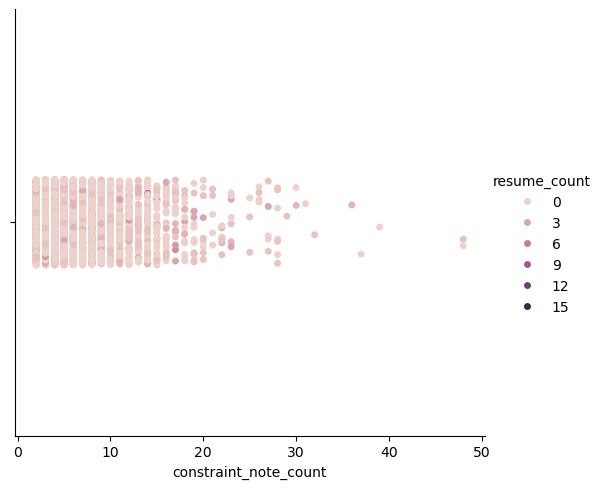

In [145]:
sns.catplot(data=features_labeled, x="constraint_note_count", hue="resume_count")

<Axes: xlabel='resume_count', ylabel='constraint_note_count'>

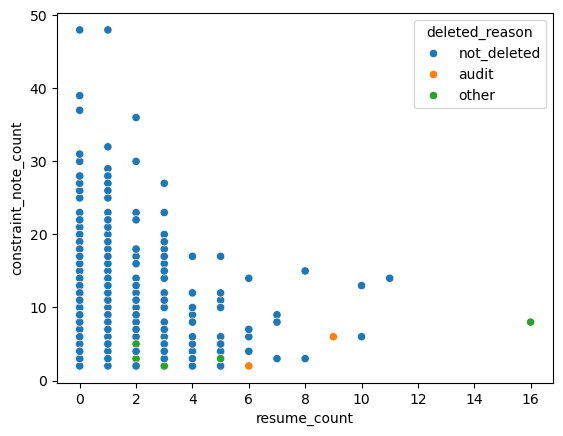

In [190]:
vc = features_labeled[[ "resume_count", "constraint_note_count"]].value_counts()


In [191]:
vc

resume_count  constraint_note_count
0             3                        1100
              4                         922
              2                         695
              5                         593
              6                         401
                                       ... 
3             20                          1
              27                          1
4             5                           1
              6                           1
16            8                           1
Name: count, Length: 133, dtype: int64

# Facet Grid

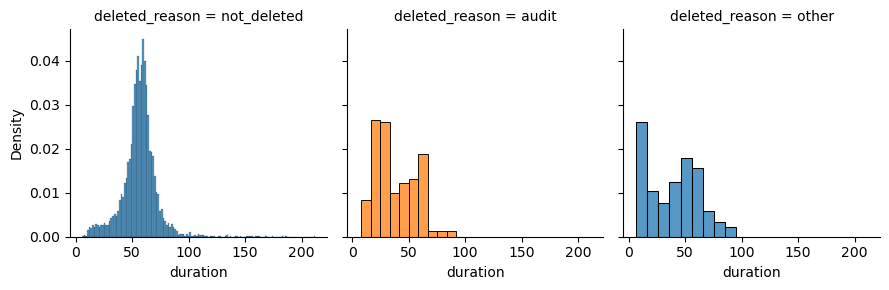

In [83]:
target = 'anomaly_label'
col_to_remove_pg = ["audit_id", "enum_id", "Calc_Enum_code_Unique_Identifier"]
df_facet_grid = features_labeled.drop(columns=col_to_remove)

g = sns.FacetGrid(df_facet_grid, col="deleted_reason", hue=target)
g.map(sns.histplot, "duration", stat="density", common_norm=True)

# Pair Grid

In [86]:
best_features = ["active_time_spent_seconds", "max_survey_start_span", "active_time_that_day_seconds", 
                 "duration", "time_per_question","resume_count", "median_active_seconds_per_day", "median_active_seconds_per_survey"]
target = 'anomaly_label'

In [102]:
# Type Features list 
constraint_features = ["resume_count", "constraint_note_count", "constraint_backtracks_count", "constraint_error_count"]

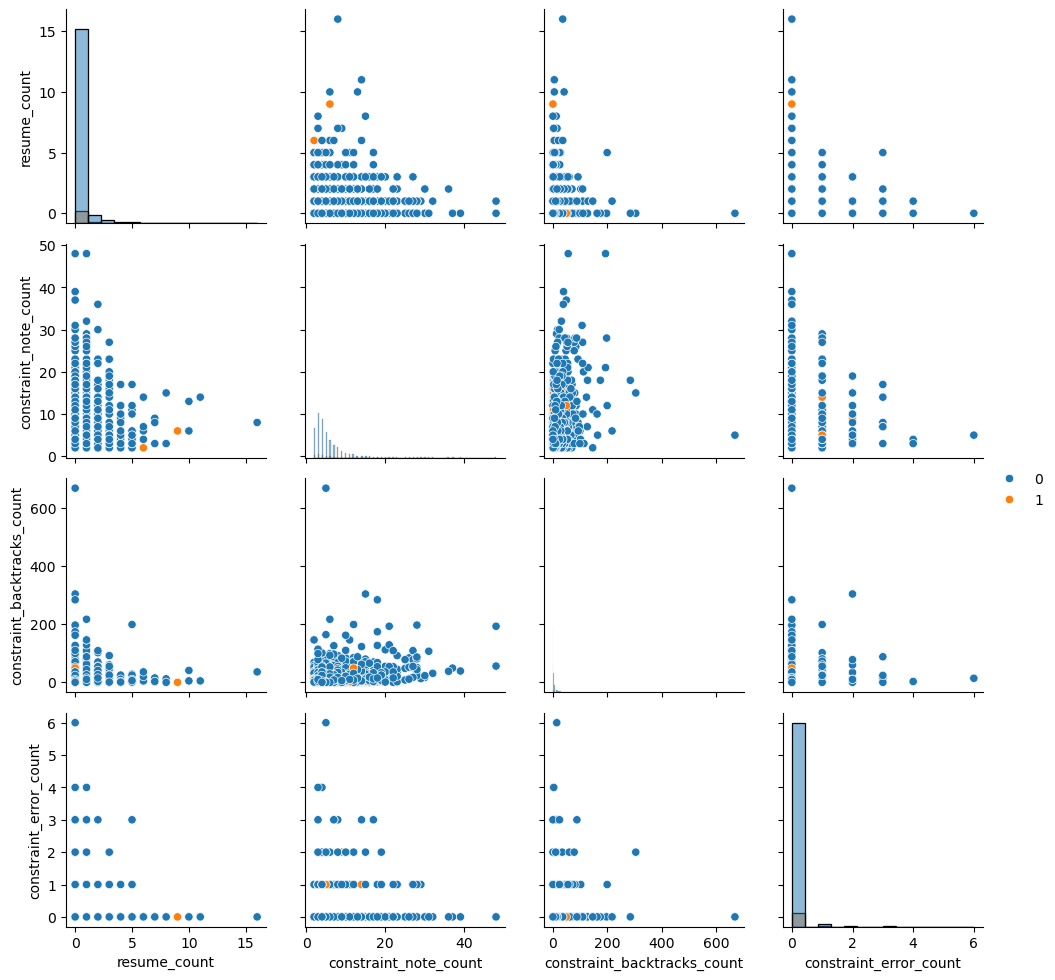

In [103]:

g = sns.PairGrid(features_labeled, vars=constraint_features, hue=target)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend(title="", adjust_subtitles=True)

# TSNE

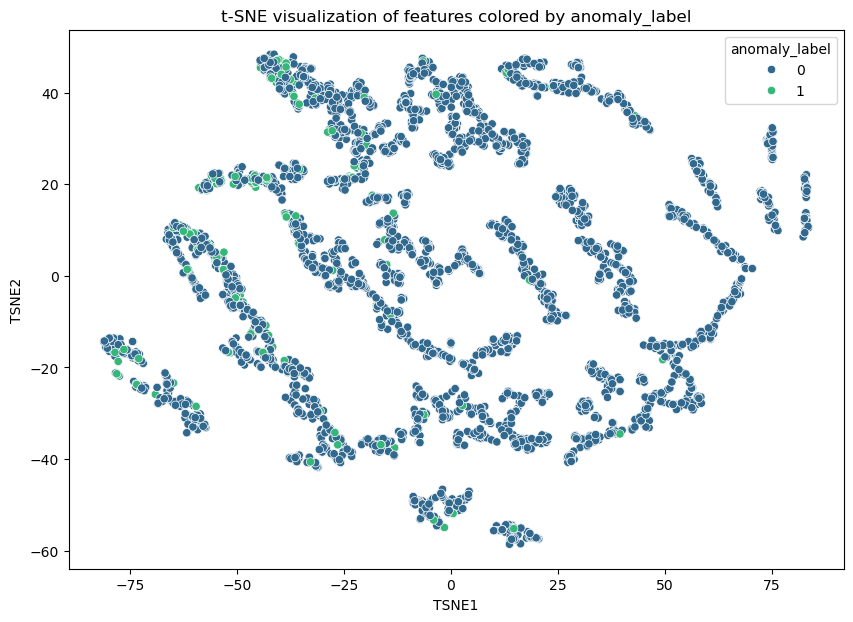

In [44]:

# Séparer les caractéristiques et la variable cible
features = df[best_features]
target = df['anomaly_label']

# Convertir les variables catégorielles en numériques
features = pd.get_dummies(features)

# Appliquer t-SNE
tsne = TSNE(n_components=2,
            perplexity=50, 
            random_state=0)
tsne_result = tsne.fit_transform(features)

# Ajouter les résultats t-SNE au DataFrame
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
df_tsne['anomaly_label'] = target

# Visualiser les résultats t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='anomaly_label', palette='viridis', data=df_tsne)
plt.title('t-SNE visualization of features colored by anomaly_label')
plt.show()

# Checks on data

In [ ]:
# Checks 
if len(dl_df) == len(dl_audit_id):
    print("Le nombre de lignes est le même après le merge (dl_df comme base).")
else:
    print("Le nombre de lignes est différent après le merge (dl_df comme base).")

# Check NA
dl_audit_id.isna().any()

# Deleted survey after merge total
deleted_surveys_filter = pd.notna(features_labeled['reason'])
deleted_surveys = features_labeled[deleted_surveys_filter]
len(deleted_surveys)

# Diff 3 because of No consent not in the kobo database
# Check the not consent or not in the features df
list_audit_id_no_consent = dl_audit_id.loc[dl_audit_id["reason"] == "No consent", "audit_id"].to_list()
features_labeled["audit_id"].isin(list_audit_id_no_consent).any()
